# N-Layer Neural Network | Text Colour Predictor

Task:
- Build a scalable feed-forward neural network.
- Input values of RGB 'background colour'.
- Predict if light or dark coloured text should be used over the RGB colour to make the text readable.

Task mapping:
- Objects of interest: RGB vectors (3 $\times$ 1 dimension).
- Labels: light text versus dark text.

Resources:
- [Feed-forward NN playground](https://playground.tensorflow.org)
- [Activation functions](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/)

## Import libraries:

In [1]:
# Import libraries:
import numpy as np # For linear algebra.
import pandas as pd # For data processing, CSV file I/O (e.g. pd.read_csv).
import matplotlib.pyplot as plt # For data visualisation.
from PIL import Image, ImageDraw, ImageFont, ImageEnhance # For data visualisation.
%matplotlib inline

## RGB class and tool functions:

In [2]:
class Error(Exception):
    """Base class for exceptions in this module."""
    pass

class InputError(Error):
    '''Exception raised for errors in the input.

    Attributes:
        expr -- Input expression in which the error occurred.
        msg  -- Explanation of the error.'''
    def __init__(self, expr, msg):
        self.expr = expr
        self.msg = msg

class RGB():
    '''Defined with values for RGB as input.
    
    Attributes:
        RGB -- Input RGB values should range from 0 to 255.
        hex -- Automatically converts RGB to hex values.'''
    def __init__(self, R, G, B):
        for X in [R, G, B]:
            if (X < 0) or (X > 255):
                raise InputError(X, 'Not an RGB value.')
        self.R = R
        self.G = G
        self.B = B
        self.RGB = (R, G, B)
        self.hex = '#{:02X}{:02X}{:02X}'.format(self.R,self.G,self.B)

def generate_RGB_data(X, extreme=False, extreme_magnitude=200):
    '''Generates a list filled with X number of RGB class values.
    Optional: generate cols that are v. dark + v. light for training.
    
    Attributes:
        X -- Number of desired RGB instances.
        extreme -- Boolean to generate v. dark + v. light cols.
        extreme_magnitude -- Int between 1 and 254.'''
    if extreme == True:
        cols = []
        for x in range(X):
            minimum = extreme_magnitude*(x%2)
            maximum = 255-(extreme_magnitude*(not x%2))
            rgb = RGB(np.random.randint(low=minimum, high=maximum),
                      np.random.randint(low=minimum, high=maximum),
                      np.random.randint(low=minimum, high=maximum))
            cols.append(rgb)
        return cols
                        
    else:
        return [RGB(np.random.randint(0, 255),
                    np.random.randint(0, 255),
                    np.random.randint(0, 255))
                for i in range(X)]

def display_RGB_colour(colour, font_col='#000'):
    '''Will draw a box of given colour;
    and fill with text of given font colour.
    
    Attributes:
        colour -- String containing a RGB or hex value.
        font_col -- String containing a RGB or hex value.'''
    img = Image.new(mode='RGB', size=(100, 100), color=colour)
    img_draw = ImageDraw.Draw(img)
    img_draw.text((36, 45), 'Text', fill=font_col)
    plt.imshow(img)
    plt.show();

## Data visualisation:

RGB: (39, 9, 29) Hex: #27091D


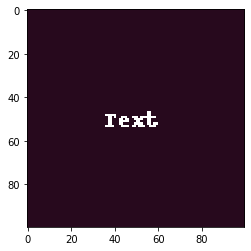

In [3]:
# Test the RGB class and data visualisation tool functions:
colours = generate_RGB_data(X=1, extreme=True, extreme_magnitude=200)

for colour in colours:
    print('RGB:', colour.RGB, 'Hex:', colour.hex)
    display_RGB_colour(colour=colour.RGB, font_col='#fff')

## Generate data:

NB: Change "extreme_magnitude" to adjust the level of noise. Default has no noise (i.e. easy to model).

In [4]:
np.random.seed(42) # Optional: set seed for data generation.
extreme_magnitude = 100 # Optional: set magnitude lower for higher error.

data = pd.DataFrame([x.RGB for x in generate_RGB_data(X=500,
                                                      extreme=True,
                                                      extreme_magnitude=extreme_magnitude)],
                     columns=['R', 'G', 'B'])

display('Training set:', data)

'Training set:'

,R,G,B
0,102,92,14
1,206,171,120
2,102,121,74
3,187,216,199
4,103,151,130
...,...,...,...
495,146,200,183
496,5,146,130
497,100,157,223
498,14,63,24


## Assign Labels

NB: This the 'lazy' method.

In [5]:
# Import libraries:
from sklearn.cluster import AgglomerativeClustering

In [6]:
clusterer = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data.values)
y = clusterer.labels_

---> light text


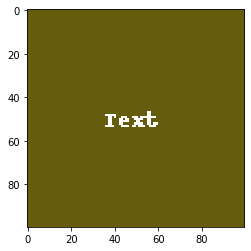

---> dark text


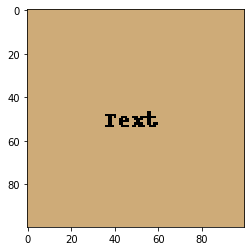

In [7]:
for i, label in enumerate(y[:2]):
    
    if label == 1: # NB: must check for most appriate label-to-class assignment.
        print('---> light text')
        display_RGB_colour(colour=tuple(data.iloc[i, :]), font_col='#fff')
        
    else:
        print('---> dark text')
        display_RGB_colour(colour=tuple(data.iloc[i, :]), font_col='#000')

## Train/test split:

In [8]:
# Import libraries:
from sklearn.model_selection import train_test_split

In [9]:
# Split data into training & testing sets:
train_temp, test_temp = train_test_split(data.join(pd.Series(y, name='y')))

display(train_temp.head())
display(test_temp.head())

,R,G,B,y
69,141,198,106,0
283,104,250,237,0
399,208,253,172,0
378,21,3,153,1
364,141,54,6,1


,R,G,B,y
290,77,116,119,0
345,217,185,162,0
293,249,159,163,0
114,14,53,100,1
439,187,110,161,0


## Preprocessing:

In [10]:
# Import libraries:
from sklearn.preprocessing import normalize

train = pd.DataFrame(np.insert(normalize(X=train_temp.values[:, :3]), 3, train_temp.values[:, 3], axis=1),
                     index=train_temp.index,
                     columns=train_temp.columns)

test = pd.DataFrame(np.insert(normalize(X=test_temp.values[:, :3]), 3, test_temp.values[:, 3], axis=1),
                    index=test_temp.index,
                    columns=test_temp.columns)

display(train.head())
display(test.head())

,R,G,B,y
69,0.531712,0.746660,0.399727,0.0
283,0.289017,0.694753,0.658626,0.0
399,0.562250,0.683891,0.464938,0.0
378,0.135954,0.019422,0.990525,1.0
364,0.933120,0.357365,0.039707,1.0


,R,G,B,y
290,0.420407,0.633341,0.649721,0.0
345,0.661665,0.564093,0.493962,0.0
293,0.737957,0.471225,0.483080,0.0
114,0.122765,0.464751,0.876889,1.0
439,0.692165,0.407156,0.595929,0.0


## Building the NN:

In [11]:
# Define Neuron class:
class NeuralNetwork():
    def __init__(self, X, y, bias=1, eta=0.1, n_nodes=2, n_layers=2, Ws=None, linear=False):
        '''Initialise internal state of network. CAUTION: when setting own Ws param,
        make sure the matrix dimensions are correct.
        
        Attributes:
        X -- Initial input vector; should be a numpy array or matrix.
        y -- Initial y_true; should be numpy array.
        Ws -- Optional. If given should be a list of numpy arrays.'''
        # Create list of LAYERS:
        self.layers = []
        self.layers.append(X) # Append input layer.
        for i in range(n_layers-1):
            self.layers.append(np.zeros((n_nodes, 1))) # Append hidden layers.
        self.layers.append(np.zeros(y.shape)) # Append output layer.

        # Create list of WEIGHTS:
        if Ws is None:
            self.Ws = []
            for i in range(n_layers):
                self.Ws.append(np.random.rand(self.layers[i+1].shape[0], self.layers[i].shape[0]))
        else:
            self.Ws = Ws

        # Create list of BIASES:
        self.biases = []
        for i in range(n_layers):
            self.biases.append(np.ones((self.Ws[i].shape[0], self.layers[i].shape[1]))*bias) # Multiply bias.

        # Set the other parameters:
        self.y_true = y
        self.eta = eta
        self.linear = linear
        self.n_layers = n_layers
    
    def activ_func(self, x):
        '''Activation function used during forward pass.'''
        # For linear:
        if self.linear is True:
            return x
        # For sigmoid:
        else:
            return 1.0/(1.0 + np.exp(-x))
    
    def forwardpass(self):
        '''Runs the forward pass algorithm using the internal state (via self).'''
        for i in range(self.n_layers):
            self.layers[i+1] = self.activ_func(np.dot(self.Ws[i], self.layers[i]) + self.biases[i])
        
    def activ_deriv(self, x):
        '''Derivative of the activation function used during backpropagation.'''
        # For linear:
        if self.linear is True:
            return 1
        # For sigmoid:
        else:
            return self.activ_func(x)*(1-self.activ_func(x))
    
    def error_deriv(self):
        '''Derivative of the error function used during backpropagation.'''
        return -(self.y_true-self.layers[-1])
    
    def error(self):
        '''Error function.'''
        return ((self.y_true-self.layers[-1])**2)*0.5
    
    def backprop(self):
        '''Runs backpropagation algorithm using the internal state (via self):
        (1) applies chain rule to find derivative of loss function;
        (2) updates the weights and biases with the gradient of the loss function.'''
        # Initialise lists to contain deltas:
        deltas = []
        
        # Iterate over n number of layers and calculate delta:
        for i in reversed(range(self.n_layers)): # NB: reversed for backpropagation.
            # Calculate the deriv wrt. activation:
            d_activ = self.activ_deriv(x=np.dot(self.Ws[i], self.layers[i]))
            
            # Delta for output layer:
            if i == self.n_layers-1:
                delta = self.error_deriv() * d_activ
                
            # Delta for subsequent layers:
            else:
                delta = np.dot(deltas[0].T, self.Ws[i+1]).T * d_activ # NB: uses the prev delta and prev layer.
                
            # Save delta to list:
            deltas.insert(0, delta) # NB: undo reversed order.

        # Iterate over deltas and apply both kinds of updates:
        for i in range(self.n_layers):
            # Update weight:
            self.Ws[i] += -self.eta * np.dot(deltas[i], self.layers[i].T)
            
            # Update bias:
            self.biases[i] += -self.eta * deltas[i] * self.biases[i]

    def fit(self, Xs, ys, iterations=1):
        '''Applies the forward pass and backpropagation algorithms in sequence to fit given training data.
        
        Attributes:
        iterations -- Number of times to repeat the sequence over whole dataset, aka epochs.'''
        y_preds = []
        
        for iteration in range(iterations): # Per iteration.
            for i, X in enumerate(Xs): # Per data point.
                # Reset inputs:
                self.layers[0] = X  # X assigned to input layer.
                self.y_true = ys[i] # y assigned to y_true.
                
                self.forwardpass()
                self.backprop()
                
                # Save the final interation of output layer:
                if iteration == iterations-1:
                    y_preds.append(self.layers[-1])
                    
        return np.array(y_preds)
    
    def predict(self, Xs):
        '''Applies forward pass using the internal state to the given input data (Xs).
        
        Attributes:
        Xs -- Input data.'''
        y_preds = []
        
        for X in Xs: # Per data point.
            self.layers[0] = X # X assigned to input layer.
            self.forwardpass()
            y_preds.append(self.layers[-1])
            
        return np.array(y_preds)
    
    def display_test_results(self, Xs, y_preds):
        '''Will plot a figure of a given colour (via Xs) and its predicted text colour (via y_preds).
        NB: specific to the "text predictor" scenario.
        
        Attributes:
        Xs -- Input data.
        y_preds -- Predicted colours.'''
        for i, y in enumerate(y_preds):
            if y == 0:
                print('\n--->\t{}:\tlight text'.format(y))
                display_RGB_colour(colour=tuple(Xs[i, :]), font_col='#fff')

            else:
                print('\n--->\t{}:\dark text'.format(y))
                display_RGB_colour(colour=tuple(Xs[i, :]), font_col='#000')

## Use NN on a dummy example:

NB: the idea behind using the dummy example is tha tit is easy to calculate by hand.

The results should be as follows:
- First ***forward pass*** output: $\begin{bmatrix} 2 \\ 2 \end{bmatrix}$
- ***Backpropagation***...
    - ... hidden layer update: $\begin{bmatrix} -1 & 0.1 \\ 0 & 0.8 \end{bmatrix}$
    - ... output layer update: $\begin{bmatrix} 0.9 & -0.2 \\ -1.2 & 0.6 \end{bmatrix}$
- Second ***forward pass*** output: $\begin{bmatrix} 1.66 \\ 0.32 \end{bmatrix}$

In [12]:
# Setup inputs:
X = np.array([0, 1]).reshape((2,1))
y = np.array([1, 0]).reshape((2,1))
Ws = [np.array([[-1, 0], [0, 1]], dtype=float),
      np.array([[1, 0], [-1, 1]], dtype=float)]

# Initialise NN:
NN = NeuralNetwork(X=X,
                   y=y,
                   bias=1,
                   eta=0.1,
                   n_nodes=2,
                   n_layers=2,
                   Ws=Ws,
                   linear=True)

# Use NN:
NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.layers[-1]))

NN.backprop()
print('\nBackpropagation:\nhidden:\n{}\noutput:\n{}'.format(NN.Ws[-2], NN.Ws[-1]))

NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.layers[-1]))


Forward Pass:
output:
[[2.]
 [2.]]

Backpropagation:
hidden:
[[-1.   0.1]
 [ 0.   0.8]]
output:
[[ 0.9 -0.2]
 [-1.2  0.6]]

Forward Pass:
output:
[[1.66]
 [0.32]]


## Train NN on the training set:

In [13]:
# Setup inputs:
input_X = train.values[0, :3].reshape((3,1))
input_y = train.values[0, 3].reshape((1,1))
print('X:\n{}\ny:\n{}'.format(input_X, input_y))

# Initialise NN:
NN = NeuralNetwork(X=input_X,
                   y=input_y,
                   bias=1,
                   eta=0.1,
                   n_nodes=5,
                   n_layers=3,
                   Ws=None,
                   linear=False)

# Use NN:
NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.layers[-1]))

NN.backprop()
print('\n...')

NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.layers[-1]))

X:
[[0.53171216]
 [0.74665963]
 [0.39972687]]
y:
[[0.]]

Forward Pass:
output:
[[0.96379088]]

...

Forward Pass:
output:
[[0.96218672]]


In [14]:
%%time

# Setup inputs:
tr_i = train.shape[0]
train_Xs = train.values[:, :3].reshape((tr_i, 3, 1))
train_ys = train.values[:,  3].reshape((tr_i, 1, 1))
print('Shapes of inputs:', train_Xs.shape, train_ys.shape)

# Train NN:
train_y_preds = NN.fit(Xs=train_Xs, ys=train_ys, iterations=1000)
print('Shape of y_preds:', train_y_preds.shape)

Shapes of inputs: (375, 3, 1) (375, 1, 1)
Shape of y_preds: (375, 1, 1)
CPU times: user 32.5 s, sys: 334 ms, total: 32.8 s
Wall time: 33.9 s


In [15]:
# Check training predictions:
print(train_y_preds.reshape(tr_i))

[0.20964974 0.4530153  0.08928957 0.999972   0.99993182 0.1016801
 0.23136438 0.77423651 0.17767207 0.07364089 0.1099726  0.0802463
 0.97896094 0.11584273 0.99130561 0.56738522 0.9952979  0.06488131
 0.99737577 0.08094883 0.78394295 0.11085763 0.91561673 0.99990646
 0.95534423 0.09498847 0.99916082 0.99852673 0.99994574 0.25537852
 0.99987019 0.9999872  0.09279699 0.47495878 0.1247536  0.06515648
 0.0607326  0.77749417 0.05876195 0.93091039 0.99962071 0.05951031
 0.08073633 0.33574317 0.08940173 0.99305161 0.32724224 0.99986819
 0.05293655 0.14429081 0.0880352  0.99740896 0.95796346 0.07380001
 0.99954507 0.16579084 0.10120093 0.99990709 0.39914797 0.87334296
 0.98420687 0.13310243 0.99648985 0.06773678 0.9960298  0.16508159
 0.99178337 0.06888328 0.30575732 0.99711829 0.0806696  0.06084192
 0.0556537  0.05359217 0.99446353 0.13376214 0.99992281 0.94944109
 0.78092272 0.06075174 0.08080635 0.06654094 0.07715548 0.20265177
 0.98484039 0.15025042 0.99982322 0.30845818 0.11848087 0.958947

In [16]:
# Check NN layers:
for i, layer in enumerate(NN.layers):
    print('Layer #{}.\n{}\n'.format(i, layer))

Layer #0.
[[0.22568437]
 [0.97366684]
 [0.03224062]]

Layer #1.
[[3.98189589e-05]
 [4.03765992e-03]
 [1.67538261e-02]
 [9.97898080e-01]
 [3.76780272e-01]]

Layer #2.
[[1.        ]
 [1.        ]
 [0.03335597]
 [1.        ]
 [0.14344641]]

Layer #3.
[[0.99997974]]



In [17]:
# Training results:
# NB: the y predictions are rounded!
train_results = pd.DataFrame({'y_true': train.y.values,
                              'y_pred': np.round(train_y_preds).reshape((tr_i,)).astype(int),
                              'same': train.y.values == np.round(train_y_preds).reshape((tr_i,)).astype(int)})

display(train_results.loc[train_results.y_pred==1])
display(train_results.loc[train_results.y_pred==0])

print('{}% error'.format(round(len(train_results[train_results.same==False]) / len(train_results) * 100)))

,y_true,y_pred,same
3,1.0,1,True
4,1.0,1,True
7,1.0,1,True
12,1.0,1,True
14,1.0,1,True
...,...,...,...
364,1.0,1,True
365,1.0,1,True
367,1.0,1,True
371,1.0,1,True


,y_true,y_pred,same
0,0.0,0,True
1,0.0,0,True
2,0.0,0,True
5,0.0,0,True
6,0.0,0,True
...,...,...,...
368,0.0,0,True
369,0.0,0,True
370,0.0,0,True
372,0.0,0,True


12% error


## Test NN on the training set:

In [18]:
# Setup inputs:
te_i = test.shape[0]
test_Xs = test.values[:, :3].reshape((te_i, 3, 1))
test_ys = test.values[:,  3].reshape((te_i, 1, 1))
print('Shapes of inputs:', test_Xs.shape, test_ys.shape)

# Test NN:
test_y_preds = NN.predict(Xs=test_Xs)
print('Shape of y_preds:', test_y_preds.shape)

Shapes of inputs: (125, 3, 1) (125, 1, 1)
Shape of y_preds: (125, 1, 1)


In [19]:
# Check testing predictions:
print(test_y_preds.reshape(test_y_preds.shape[0]))

[0.08195872 0.10621551 0.19184287 0.99891081 0.24293983 0.99562556
 0.42458755 0.36531196 0.07746034 0.99220545 0.99987336 0.08923697
 0.20135329 0.99779459 0.84345203 0.74572189 0.99793823 0.10947035
 0.0968603  0.99890079 0.99826337 0.99984643 0.99989754 0.17661948
 0.19032471 0.13059371 0.08391629 0.09907688 0.11109532 0.50685116
 0.20432883 0.08949567 0.07373518 0.96701185 0.14203661 0.07148338
 0.11929294 0.99851058 0.14523523 0.07695484 0.08587336 0.17991341
 0.99996474 0.07412134 0.98367863 0.17690687 0.08846053 0.99689372
 0.38793711 0.19215807 0.9998459  0.99983521 0.24577348 0.09122481
 0.44050245 0.28961966 0.77732938 0.13231827 0.72068224 0.10427838
 0.99967415 0.99997676 0.26638025 0.99994983 0.07235173 0.20748846
 0.99993037 0.08257075 0.08049338 0.1370033  0.99018161 0.99984251
 0.10605237 0.99985652 0.07293547 0.20377909 0.93971474 0.99998814
 0.32216931 0.32035895 0.10627947 0.59026684 0.99910007 0.98606784
 0.17073372 0.99997995 0.55406379 0.08959864 0.31018273 0.1460

In [20]:
# Testing results:
# NB: the y predictions are rounded!
test_results = pd.DataFrame({'y_true': test.y.values,
                             'y_pred': np.round(test_y_preds).reshape((te_i,)).astype(int),
                             'same': test.y.values == np.round(test_y_preds).reshape((te_i,)).astype(int)})

display(test_results.head(15))

print('{}% error'.format(round(len(test_results[test_results.same==False]) / len(test_results) * 100)))

,y_true,y_pred,same
0,0.0,0,True
1,0.0,0,True
2,0.0,0,True
3,1.0,1,True
4,0.0,0,True
5,1.0,1,True
6,0.0,0,True
7,0.0,0,True
8,0.0,0,True
9,1.0,1,True


11% error


# Compare against NN via scikit-learn

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
# Setup the sklearn neural network
sklearn_NN = MLPClassifier(activation='logistic',
                           solver='sgd',
                           max_iter=1000) # NB: 'logistic' and stochastic gd chosen for fair comparison.

# View description
sklearn_NN

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [23]:
# Optimise parameters via a gridsearch:
sklearn_grid = GridSearchCV(estimator=sklearn_NN,
                            param_grid={'hidden_layer_sizes': [5, 50, 100],
                                        'learning_rate_init': [0.1, 0.01, 0.001],
                                        'alpha': [0.1, 0.01, 0.001]},
                            cv=5)

In [24]:
# Train sklearn NN:
sklearn_grid.fit(X=train.iloc[:, :3].values,
                 y=train.y.values)

print('best parameters:\t{}'.format(sklearn_grid.best_params_))

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters:	{'alpha': 0.001, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.1}


In [25]:
# Test sklearn NN:
sklearn_y_preds = sklearn_grid.predict(X=test.iloc[:, :3].values)

In [26]:
# Display the sklearn predictions:
sklearn_results = pd.DataFrame({'y_true': test.y.values,
                                'y_pred': sklearn_y_preds,
                                'same': test.y.values == sklearn_y_preds})

display(sklearn_results.head(10))

# Print error:
print('{}% error'.format(round(len(sklearn_results[sklearn_results.same==False]) / len(sklearn_results) * 100)))

,y_true,y_pred,same
0,0.0,0.0,True
1,0.0,0.0,True
2,0.0,0.0,True
3,1.0,1.0,True
4,0.0,0.0,True
5,1.0,1.0,True
6,0.0,0.0,True
7,0.0,0.0,True
8,0.0,0.0,True
9,1.0,1.0,True


11% error


In [27]:
# The end.